# 모델 평가

### 기존 개발 vs AI 개발
- 기존 개발 : 유닛 테스트, E2E 테스트 -> QA (품질보증, Quality Assurance)
- AI 개발 : 모델 평가 -> QA

### 모델 학습 및 배포 과정
- 데이터 취득 -> 모델 학습 -> 모델 평가 -> 모델 배포
- 모델 평가
  - 모델 검증
  - 모델 성능 지표 분석
  - 사용자 동작 테스트
  - 모델 모니터링 (off line (online 되기 전), online의 경우 실제 배포 후 성능지표)

### 모델 평가 과정
- Model Validation (학습)
- Model Evaluation
  - 모델 출력 분포 다양한 매트릭으로 정밀 분석
- Behavior Testing
  - 시나리오 테스트
  - 사용자 결과 테스트


### 주요 평가 메트릭
- 정확도 (Accuracy)
- F1 Score
  - 정밀도, 재현율 적절히 혼용
  - 모델의 정확도가 높더라도 샘플수가 적어서 편향될 수 있다.
- 정밀도 (Precision)
- 재현율 (Recall)
  - 모델 평가한 것 중 제대로 맞는 비율은?
  - 잘못 예측한 Positive를 줄이는 것이 목적
- 분류 성능 평가 지표
  - 실제 Positive 데이터 중 모델이 맞춘 비율은 어느정도?
  - 모델이 Positive 놓치는 것이 없도록 집중
- 드리프트 (Drift)
  - 모델이 잘 학습되었다 하더라도 실제 분포와 다를 수 있는데, 이 차이를 드리프트(Drift)라고 부른다.

## 분류 모델 학습 및 평가 실습

### 분류 모델
- 뉴스 카테고리 분류
- 과정
  - AG News 입력 -> BertForSequenceClassification -> 0 World, 1 Sports, 2 Business, 3 Sci/Tech
- BertForSequenceClassification
  - Bert는 경량데이터, 12만개중에서 1200개만 학습 돌릴 예정
- huggingface
  - 모델 및 데이터 등록 사이트 (GitHub와 비슷)

### 시나리오

```mermaid
A_1["데이터 셋 전처리"]-->B["모델 학습"]-->C["모델 평가"]
A_2["BERT 모델 다운로드"]-->B
C-->C_1["Accuracy 평가"]
C-->C_2["Precision, Recall, F1 Score 평가"]
C-->C_3["Confusion Matrix 평가"]
C-->C_4["ROC Curve 평가"]
```
- ROC Curve
  - Threshold에 따라 True Positive Rate(TPR)와 False Positive Rate(FPR)을 바탕으로 나타낸 모델 성능 그래프
  - 그래프 밑면의 넓이가 넓을 수록 모델 성능이 좋음
  - 대각선은 랜덤

### 주의사항
- Local은 느리고, colab이 더 빠릅니다.
- https://drive.google.com/drive/folders/1buIiJqWAfk2pKSfzZphuM6KwQtdPbg2a

### Import

### 모델 학습 Error
ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).

In [ ]:
%conda uninstall numpy
%conda install numpy<2

In [ ]:
%pip install datasets # huggingface에서 데이터 가져옮
%conda install transformers
%pip install -U scikit-learn
%pip install -U matplotlib
%conda install seaborn

In [6]:
%conda install tqdm

264.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Channels:
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # 좀더 복잡한 시각화

from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW # huggingface에서 bert모델가져올때 씀
from datasets import load_dataset
from tqdm import tqdm # progress 시각화
from typing import TypedDict # typing, mytyping 유지보수 좋게 해줌

# 머신러닝 함수 제공
from sklearn.metrics import auc, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve
from sklearn.preprocessing import label_binarize

### AG_News
- Dataset
  - https://huggingface.co/dtasets/ag_news

In [8]:
dataset = load_dataset("ag_news")

Generating test split: 100%|██████████| 7600/7600 [00:00<00:00, 518126.72 examples/s]


### Bert Base Uncased Model
- 110M param (경량)
- https://huggingface.co/bert-base-uncased
  - <img src="https://www.researchgate.net/profile/Mashrin-Srivastava/publication/357987621/figure/fig2/AS:1114523993948163@1642734635345/Top-Left-BERT-encoder-with-bert-base-uncased-backend-Bottom-Left-Encoding-meta.ppm">
- image link: https://www.researchgate.net/figure/Top-Left-BERT-encoder-with-bert-base-uncased-backend-Bottom-Left-Encoding-meta_fig2_357987621

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # 학습을 위한 문자 인코딩
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenizer

In [10]:
class DatasetItem(TypedDict): # Dictiornay를 TypedDict로 정의 가능
    text:str
    label:str

def preprocess_data(dataset_item: DatasetItem) -> dict[str, torch.Tensor]: # dictionary는 각각 타입을 지정해줘야 한다.
    return tokenizer(dataset_item["text"], truncation=True, padding="max_length", return_tensors="pt")
    # dataset_item.text와 같이 쉽게 데이터 바로 사용가능 (단점 리소스가 많이 듦)

### 데이터 전처리

In [11]:
train_dataset = dataset["train"].select(range(1200)).map(preprocess_data, batched=True)
test_dataset = dataset["test"].select(range(800)).map(preprocess_data, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Map: 100%|██████████| 800/800 [00:04<00:00, 195.94 examples/s]


### 전처리 완료 데이터
- label : 뉴스 분류
- input_ids : 토큰화된 텍스트 데이터
- token_type_ids : 여러 문장에 한하여, Bert에 입력되는 두개의 시퀀스를 구분 (모두 0으로 적용)
- attension_mask : 시퀀스의 각 위치가 실제 데이터인지, 패딩을 위한 추가부분인지를 나타내는 마스크 (실제 1, 패딩은 0)

In [12]:
train_dataset.to_pandas()

,text,label,input_ids,token_type_ids,attention_mask
0,Wall St. Bears Claw Back Into the Black (Reute...,2,"[101, 2813, 2358, 1012, 6468, 15020, 2067, 204...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,"[101, 18431, 2571, 3504, 2646, 3293, 13395, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,"[101, 3514, 1998, 4610, 6112, 15768, 1005, 176...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,"[101, 5712, 9190, 2015, 3514, 14338, 2013, 236...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"Oil prices soar to all-time record, posing new...",2,"[101, 3514, 7597, 2061, 2906, 2000, 2035, 1011...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...
1195,Airline Looks to Delay Its Pension Payments In...,2,"[101, 8582, 3504, 2000, 8536, 2049, 11550, 105...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1196,McDonald's Goes for Gold For a four-year inves...,2,"[101, 9383, 1005, 1055, 3632, 2005, 2751, 2005...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1197,Auction for Shares In Google's IPO May End Tod...,3,"[101, 10470, 2005, 6661, 1999, 8224, 1005, 105...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1198,"Four Firms Buy Intelsat Intelsat Ltd., the pio...",3,"[101, 2176, 9786, 4965, 13420, 16846, 13420, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [13]:
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss() # Loss Function

/usr/local/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### 모델 학습

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        inputs = {key: batch[key].to(device) for key in batch}
        labels = inputs.pop("label")
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {average_loss}")

Epoch 1: 100%|██████████| 150/150 [17:18<00:00,  6.92s/it]


Epoch 1, Average Loss: 0.2948041465381781


Epoch 2: 100%|██████████| 150/150 [20:13<00:00,  8.09s/it]


Epoch 2, Average Loss: 0.1775031436296801


Epoch 3: 100%|██████████| 150/150 [21:35<00:00,  8.64s/it]

Epoch 3, Average Loss: 0.09283606642857194


In [16]:
# 모델 체크포인트 저장.
model_save_path = "../bert_news_classification_model.pth"
torch.save(model.state_dict(), model_save_path)

### 모델 평가 (Accuracy)

In [17]:
model.eval()  # 모델을 평가 모드로 전환
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        inputs = {key: batch[key].to(device) for key in batch}
        labels = inputs.pop("label")
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total

print(f"\nTest Accuracy:: {accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Test Accuracy:: 83.62%


### 모델 평가 (Confusion Matrix)

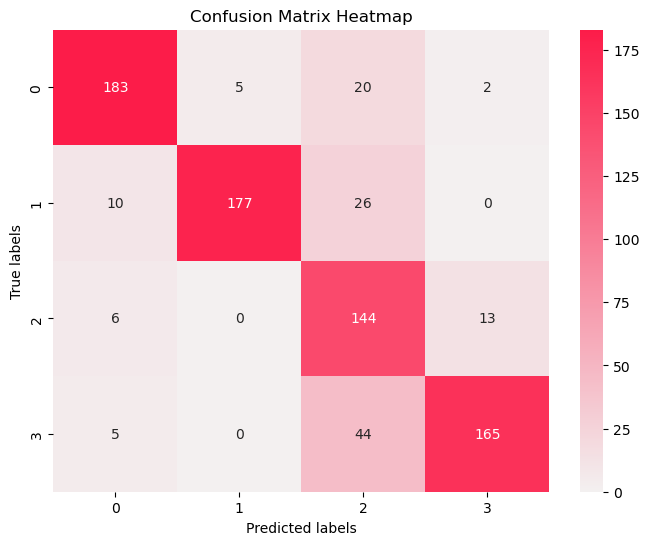

In [18]:
all_predictions: list[int] = []
all_labels: list[int] = []
all_probabilities: list[float] = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: batch[key].to(device) for key in batch}
        labels = inputs.pop("label")
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        probabilities = F.softmax(logits, dim=1)

        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap=sns.light_palette("#fc1c49", as_cmap=True))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

### 모델 평가 (Precision, Recall, F1 score)

/tmp/ipykernel_1659/640389383.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Metrics", y="Values", data=metrics_data, palette=["#fc1c49", "#00a67d", "#ffa71b", "#6f42c1"])


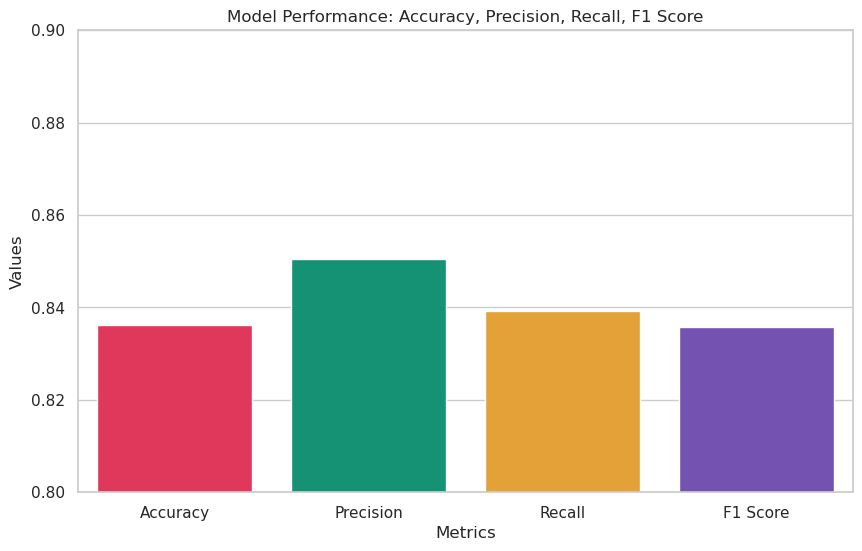

In [19]:
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average="macro")

metrics_data = {
    "Metrics": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Values": [accuracy, precision, recall, f1]
}

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Metrics", y="Values", data=metrics_data, palette=["#fc1c49", "#00a67d", "#ffa71b", "#6f42c1"])
ax.set_ylim(0.8, 0.9)
plt.title("Model Performance: Accuracy, Precision, Recall, F1 Score")
plt.show()

### 모델 평가 (ROC)

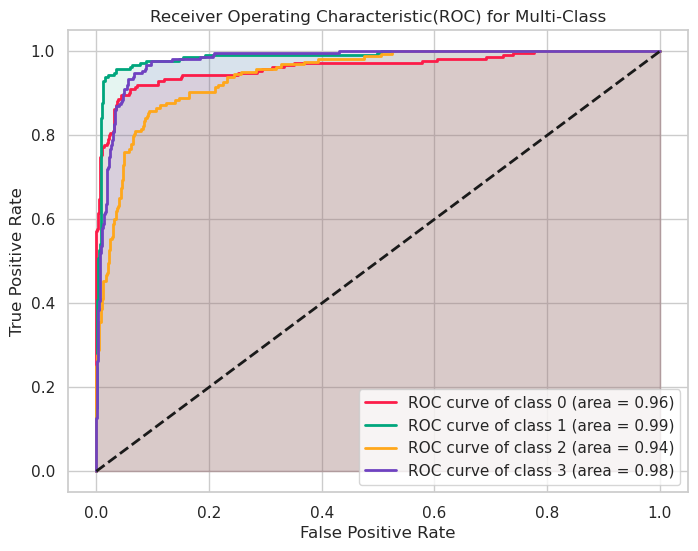

In [20]:
binary_labels = label_binarize(all_labels, classes=[0, 1, 2, 3])
all_probabilities = np.array(all_probabilities)

n_classes = binary_labels.shape[1]
fpr: dict[int, float] = {}
tpr: dict[int, float] = {}
roc_auc: dict[int, float] = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], all_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

colors = ["#fc1c49", "#00a67d", "#ffa71b", "#6f42c1"]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {i} (area = {roc_auc[i]:.2f})")
    plt.fill_between(fpr[i], tpr[i], color=color, alpha=0.1)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic(ROC) for Multi-Class")
plt.legend(loc="lower right")
plt.show()

In [22]:
# Ease-out quart 함수 정의
def ease_out_quart(x):
    return 1 - (1 - x) ** 4

# Ease-out quart 그래프 형태로 수정된 ROC 커브 생성
# Best 커브를 더 완만하게 만들고 Good 커브를 더 가파르게 만들어 Best와 Good을 서로 바꿉니다.

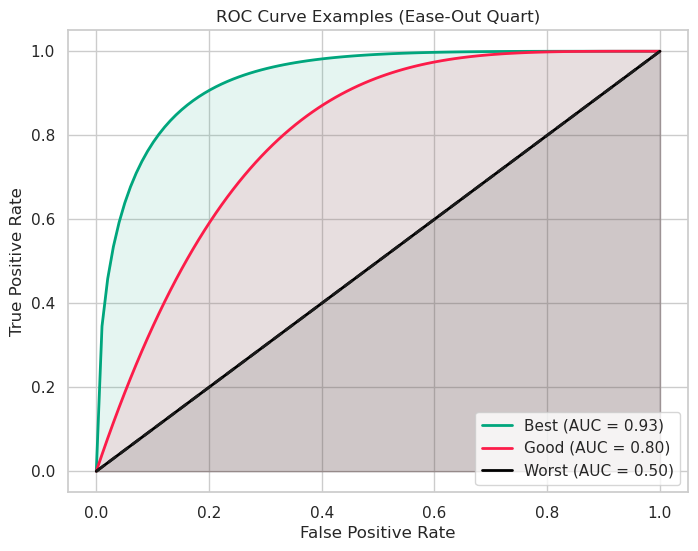

In [23]:
# Best 커브 생성
fpr = np.linspace(0, 1, 100)
tpr_best = ease_out_quart(np.sqrt(fpr))  # 더 완만한 상승을 위해 제곱근을 사용

# Good 커브 생성
tpr_good = ease_out_quart(fpr)  # 더 가파른 상승

# Worst 커브 생성 (대각선)
tpr_worst = fpr

# 각 커브의 AUC 계산
auc_best = auc(fpr, tpr_best)
auc_good = auc(fpr, tpr_good)
auc_worst = auc(fpr, tpr_worst)

# ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr_best, color="#00a67d", lw=2, label=f"Best (AUC = {auc_best:.2f})")
plt.fill_between(fpr, tpr_best, color="#00a67d", alpha=0.1)
plt.plot(fpr, tpr_good, color="#fc1c49", lw=2, label=f"Good (AUC = {auc_good:.2f})")
plt.fill_between(fpr, tpr_good, color="#fc1c49", alpha=0.1)
plt.plot(fpr, tpr_worst, color="#000000", lw=2, label=f"Worst (AUC = {auc_worst:.2f})")
plt.fill_between(fpr, tpr_worst, color="#000000", alpha=0.1)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Examples (Ease-Out Quart)")
plt.legend(loc="lower right")
plt.show()

### 종료 이후 numpy 복귀

In [ ]:
%conda uninstall numpy
%conda install numpy